In [1]:
from pathlib import Path
parent_dir = str(Path.cwd().parent)
%cd $parent_dir

D:\OrenRichter\Research\pyERGM


D:\OrenRichter\Research\pyERGM\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from utils import *
from ergm import ERGM
from metrics import *

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


# Replicating the `Sampson` example from R's ERGM
The original R ERGM paper (Hunter et al. 2008) begins with a basic example of modeling Sampson's Monestary data, which consists of a directed network with $n=18$ nodes. This network models social interactions among a group of monks (See Sampson 1969 for more details). 

In the paper, An ERGM model is fit based on the Sampson network, using `num_of_edges` as its sole feature. The R fit yields a coefficient of `-0.9071582`, which is our aim.

In [5]:
# Matrix copied manually, TODO - Create a `data` dir in our project and save as a pickle or something.
sampson_matrix = np.array(
    [[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1], 
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 
    [1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 
    [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
    [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], 
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0], 
    [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], 
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], 
    [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]]
)


Initial thetas - [0.46581701]
optimization started
Step 1 - lr: 0.0500000000, time from start: 0.04, sample_size: 500, sliding_grad_window_k: 20
	 Sample size increased at step 50 to 525
Step 51 - lr: 0.0450000000, time from start: 1.18, sample_size: 525, sliding_grad_window_k: 21
	 Sample size increased at step 100 to 551
Step 101 - lr: 0.0405000000, time from start: 2.50, sample_size: 551, sliding_grad_window_k: 23
Reached a confidence of 0.95 with the hotelling convergence test! DONE! 
hotelling - 0.0, hotelling_critical_value=0.003935730375712225


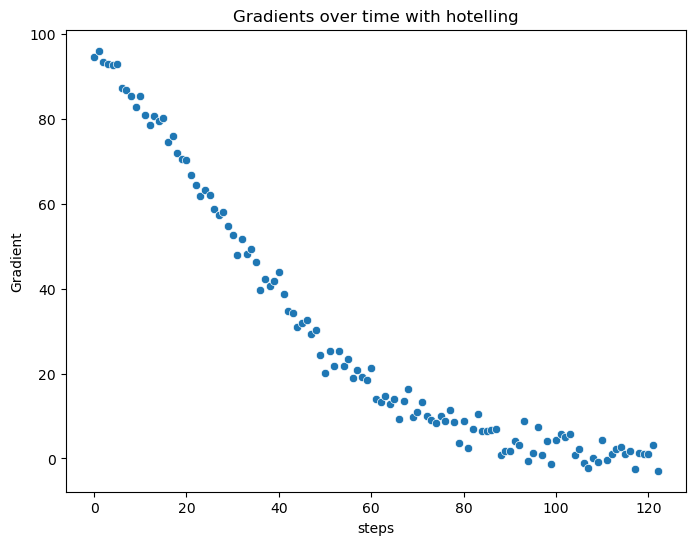

Fitted theta: [-0.88204551]


In [34]:
n = sampson_matrix.shape[0]
is_directed = True

number_of_edges_metric = NumberOfEdgesDirected() if is_directed else NumberOfEdgesUndirected()
fitted_model = ERGM(n, [number_of_edges_metric], is_directed=is_directed, sample_size=500, n_mcmc_steps=50)

convergence_criterion = "hotelling"
grads, hotelling = fitted_model.fit(sampson_matrix, lr=0.05, opt_steps=300, 
                         lr_decay_pct=0.1, steps_for_decay=50,
                         sliding_grad_window_k=20, sample_pct_growth=0.05, 
                         convergence_criterion=convergence_criterion, 
                         optimization_method="newton_raphson",
                         hotelling_confidence=0.95
                         )

grads = [x[0] for x in grads]


fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(grads, ax=ax)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title(f"Gradients over time with {convergence_criterion}")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

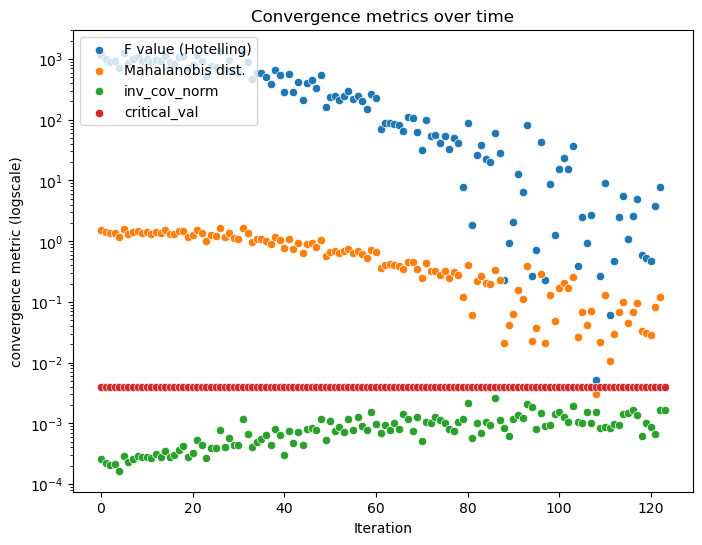

In [35]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.",  "inv_cov_norm", "critical_val",], loc="upper left")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")


plt.show()


As we can see, our model reaches a theta that is extremely close to the actual R result.

In [7]:
min(hotelling)

3.6470473599830022

10847918.021540165

## Now test a model with TotalReciprocity + NumberOfEdges

Initial thetas - [ 0.57095926 -0.14783974]
optimization started
Step 1 - lr: 0.0500000000, time from start: 0.04, sample_size: 500, sliding_grad_window_k: 20
	 Sample size increased at step 50 to 525
Step 51 - lr: 0.0450000000, time from start: 1.35, sample_size: 525, sliding_grad_window_k: 21
	 Sample size increased at step 100 to 551
Step 101 - lr: 0.0405000000, time from start: 2.72, sample_size: 551, sliding_grad_window_k: 23
	 Sample size increased at step 150 to 578
Step 151 - lr: 0.0364500000, time from start: 4.13, sample_size: 578, sliding_grad_window_k: 25
	 Sample size increased at step 200 to 606
Step 201 - lr: 0.0328050000, time from start: 5.59, sample_size: 606, sliding_grad_window_k: 27
Reached a confidence of 0.95 with the hotelling convergence test! DONE! 
hotelling - 0.042725689608504966, hotelling_critical_value=0.05129765059783868


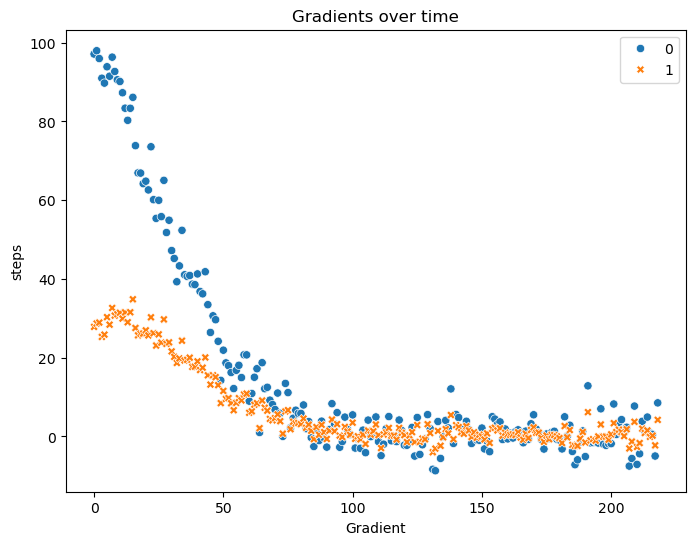

Fitted theta: [-1.7869004   2.37748828]


In [30]:
n = sampson_matrix.shape[0]
is_directed = True

number_of_edges_metric = NumberOfEdgesDirected() if is_directed else NumberOfEdgesUndirected()

estimated_p_seed = np.sum(sampson_matrix) / (n*(n-1))

metrics = [number_of_edges_metric, TotalReciprocity()]
fitted_model = ERGM(n, metrics, is_directed=is_directed, sample_size=500, n_mcmc_steps=20, seed_MCMC_proba=estimated_p_seed)

# convergence_criterion = "zero_grad_norm"
convergence_criterion = "hotelling"
grads, hotelling = fitted_model.fit(sampson_matrix, lr=0.05, opt_steps=500, 
                         lr_decay_pct=0.1, steps_for_decay=50,
                         sliding_grad_window_k=20, sample_pct_growth=0.05, 
                         convergence_criterion=convergence_criterion, 
                         optimization_method="newton_raphson",
                         hotelling_confidence=0.95
                         )

# grads, _ = fitted_model.fit(sampson_matrix, lr=1, opt_steps=400, sliding_grad_window_k=20, sample_pct_growth=0.05, lr_decay_pct=0.1, steps_for_decay=10)


fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(grads, ax=ax)
ax.set(xlabel='Gradient', ylabel='steps')
ax.set_title("Gradients over time")

plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

#### Took a while (~1 minute), but results are pretty close!
True results in R -
* $\theta_1 = -1.7625$
* $\theta_2 = 2.3132$

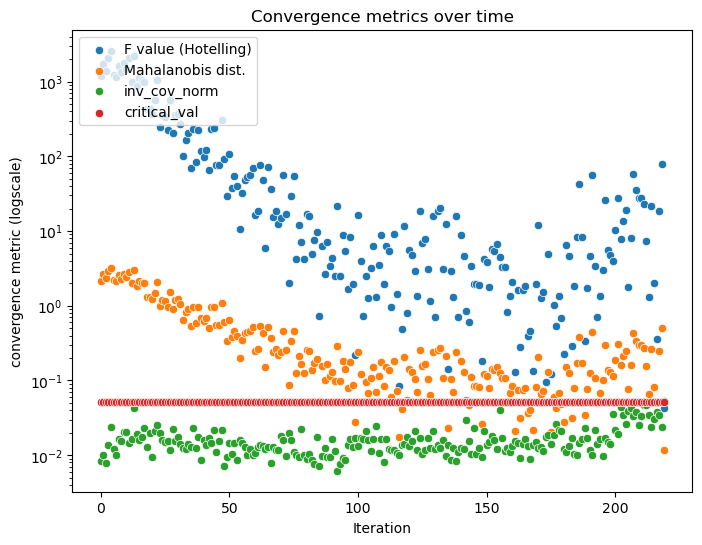

In [31]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.",  "inv_cov_norm", "critical_val",], loc="upper left")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")


plt.show()


## And finally we test the full $p_1$ model

In [ ]:
n = sampson_matrix.shape[0]
is_directed = True



estimated_p_seed = np.sum(sampson_matrix) / (n*(n-1))

metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]

fitted_model = ERGM(n, metrics, is_directed=is_directed, sample_size=1000, n_mcmc_steps=20, seed_MCMC_proba=estimated_p_seed)

# convergence_criterion = "zero_grad_norm"
convergence_criterion = "hotelling"

hotelling_conf = 0.9
grads, hotelling = fitted_model.fit(sampson_matrix, lr=0.05, opt_steps=100, 
                         lr_decay_pct=0.1, steps_for_decay=25,
                         sliding_grad_window_k=20, sample_pct_growth=0.05, 
                         convergence_criterion=convergence_criterion, 
                         optimization_method="newton_raphson",
                         hotelling_confidence=hotelling_conf,
                         cov_matrix_estimation_method="multivariate_initial_sequence"
                         # cov_matrix_estimation_method="batch"
                                    )

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(grads, ax=ax, legend=False)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title("Gradients over time")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

Initial thetas - [ 0.89274181  0.29564625  0.9476342  -0.37803466  0.34355592 -0.21580678
 -0.68409703  0.65372275 -0.03634252  0.8195284  -0.4329305   0.16153211
  0.28859916 -0.90105397  0.59109511 -0.12648915 -0.22260472  0.0068566
  0.57003278  0.50740715 -0.76276195  0.48803874  0.1152576  -0.6635351
  0.61639595  0.56253915  0.719192   -0.86296108  0.52182182  0.13938047
 -0.92735187 -0.58598472  0.50676015  0.26923957 -0.49955413  0.65124155]
optimization started
Step 1 - lr: 0.0500000000, time from start: 0.16, window_grad: 14.04


In [50]:
df["hotelling_F"].min()

2.053797499134223

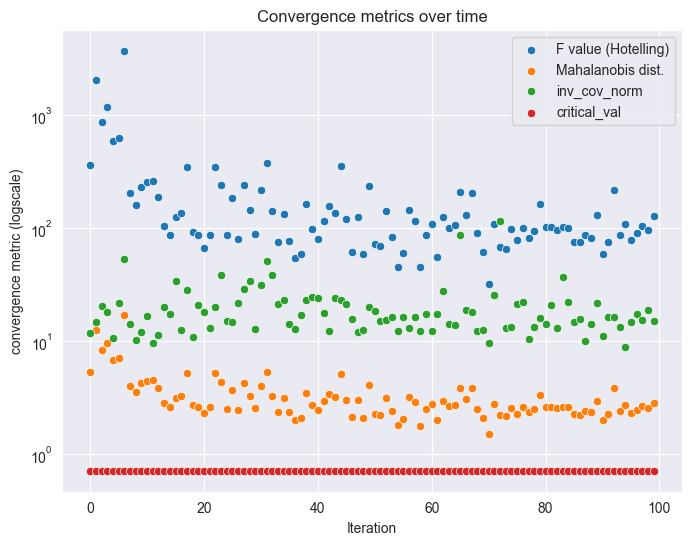

In [7]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.",  "inv_cov_norm", "critical_val",], loc="upper right")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")


plt.show()


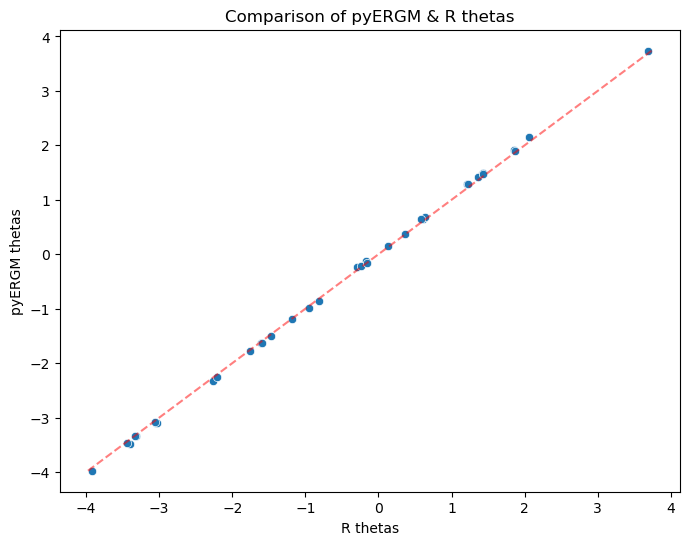

In [9]:
true_values = {"edges":      -1.1761, "sender2":    -0.2945, "sender3":     1.4141, "sender4":     0.3662, "sender5":     0.1315, "sender6":     1.2148, "sender7":     0.6055,
"sender8":     1.3609, "sender9":     0.6402, "sender10":    2.0639, "sender11":    1.4355, "sender12":   -0.1681, "sender13":   -0.2322, "sender14":    0.5841, "sender15":    1.8600,
"sender16":    1.4317, "sender17":    1.2211, "sender18":    1.8724, "receiver2":  -0.1522, "receiver3":  -3.0453, "receiver4":  -1.7596, "receiver5":  -0.8198, "receiver6":  -3.3922,
"receiver7":  -1.6074, "receiver8":  -2.2656, "receiver9":  -2.2069, "receiver10": -3.9189, "receiver11": -3.0257, "receiver12": -0.9457, "receiver13": -1.4749, "receiver14": -1.5950,
"receiver15": -3.3147, "receiver16": -3.0567, "receiver17": -3.4436, "receiver18": -3.3239, "mutual":       3.6918
}

true_predictions = np.array(list(true_values.values()))
fitted_thetas = fitted_model._thetas

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=true_predictions, y=fitted_thetas)

min_x = min(min(true_predictions), min(fitted_thetas))
max_x = max(max(true_predictions), max(fitted_thetas))

sns.lineplot(x=[min_x, max_x], y=[min_x, max_x], color="red", linestyle="--", alpha=0.5)
ax.set(xlabel='R thetas', ylabel='pyERGM thetas')
ax.set_title("Comparison of pyERGM & R thetas")
plt.show()


<Axes: ylabel='critical_val'>

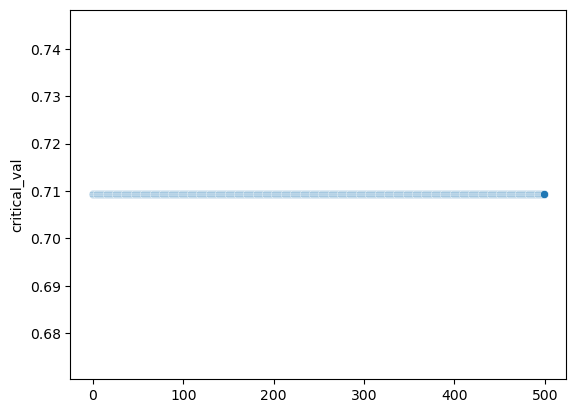

In [40]:
sns.scatterplot(df["critical_val"])

In [3]:
gals_data = pd.read_csv("./connectome_data.csv")
gals_data = gals_data.drop("Unnamed: 0", axis=1)

W = gals_data.values

W = W[:50, :50]

n = W.shape[0]
is_directed = True

estimated_p_seed = np.sum(W) / (n*(n-1))

metrics = [NumberOfEdgesDirected(), TotalReciprocity()]
# metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]

fitted_model = ERGM(n, metrics, is_directed=is_directed, sample_size=5000, n_mcmc_steps=n, seed_MCMC_proba=estimated_p_seed)

# # convergence_criterion = "zero_grad_norm"
convergence_criterion = "hotelling"

hotelling_conf = 0.9
grads, hotelling = fitted_model.fit(W, lr=0.5, opt_steps=100, 
                         lr_decay_pct=0.01, steps_for_decay=1,
                         sliding_grad_window_k=5, sample_pct_growth=0.05, 
                         convergence_criterion=convergence_criterion, 
                         optimization_method="newton_raphson",
                         hotelling_confidence=hotelling_conf,
                         cov_matrix_estimation_method="multivariate_initial_sequence"
                         )

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(grads, ax=ax, legend=False)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title("Gradients over time")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

FileNotFoundError: [Errno 2] No such file or directory: './connectome_data.csv'

In [7]:
df

,dist,hotelling_F,critical_val,inv_cov_norm,inv_hessian_norm
0,1.511810,11426.702938,0.105362,0.000254,0.016926
1,1.470946,10817.329151,0.105362,0.000262,0.013969
2,1.132893,6416.588952,0.105362,0.000124,0.016196
3,1.075460,5782.491057,0.105362,0.000102,0.012729
4,1.230048,7564.338370,0.105362,0.000114,0.014183
...,...,...,...,...,...
95,1.257223,7902.263932,0.105362,0.000138,0.012573
96,1.173751,6887.772751,0.105362,0.000151,0.015951
97,1.407260,9900.915087,0.105362,0.000237,0.016778
98,1.376713,9475.745038,0.105362,0.000194,0.013799


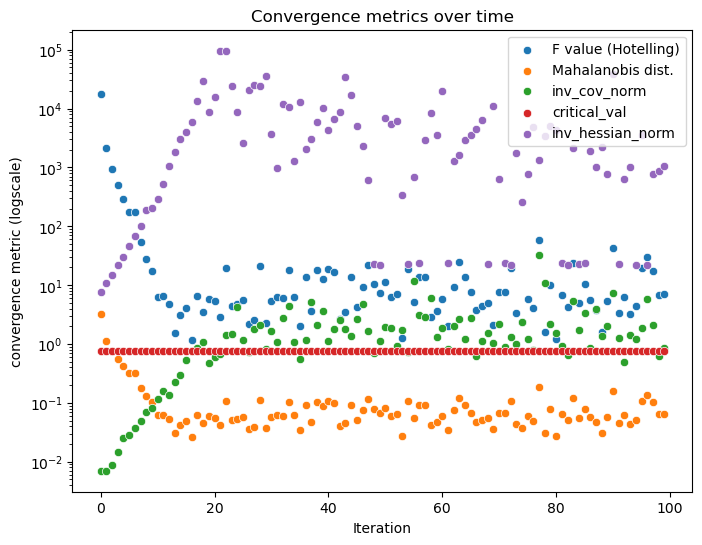

In [8]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

sns.scatterplot(df["inv_hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.",  "inv_cov_norm", "critical_val", "inv_hessian_norm"], loc="upper right")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")


plt.show()


<Axes: >

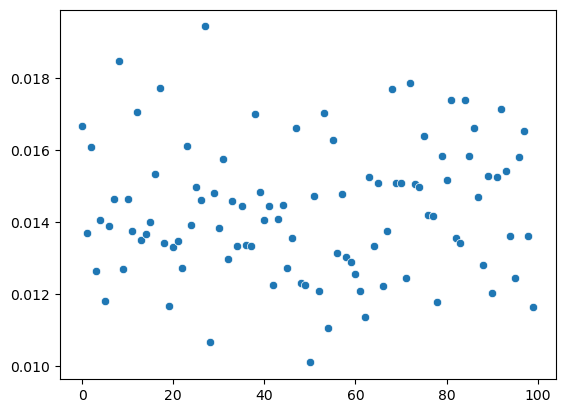

In [12]:
sns.scatterplot(df["inv_hessian_norm"] - df["inv_cov_norm"])